In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device = {device}")

device = cuda


In [2]:
import torchvision
data = torchvision.datasets.MNIST(root="./", download=True)
train_data = data.data
dl = DataLoader(train_data, batch_size=192)
print(f"data.shape = {list(train_data.shape)}")
print(f"batch size = {train_data.shape[0]}")
print(f"data shape = {list(train_data.shape[1:])} ")


100%|██████████| 9912422/9912422 [00:00<00:00, 30112030.95it/s]


Extracting ./MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 1653458.73it/s]


Extracting ./MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 10304400.89it/s]


Extracting ./MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST\raw

data.shape = [60000, 28, 28]
batch size = 60000
data shape = [28, 28] 


In [3]:
h, z_size = 1024, 2
encoder = nn.Sequential(
    nn.Linear(28*28, h),
    nn.ReLU(),
    nn.Linear(h, h),
    nn.ReLU(),
    nn.Linear(h, z_size*2)
)
decoder = nn.Sequential(
    nn.Linear(z_size, h),
    nn.ReLU(),
    nn.Linear(h, h),
    nn.ReLU(),
    nn.Linear(h, 28*28),
    nn.Sigmoid()
)
model = nn.Sequential(encoder, decoder).to(device)


In [4]:
opt = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
def vae_loss(x, x_hat, mean, logvar):
    recon_loss = torch.nn.functional.binary_cross_entropy(x_hat, x)
    
    var = torch.exp(logvar)
    kl_loss = 0.5 * torch.mean(mean**2 + var - logvar - 1)
    return recon_loss, kl_loss

In [5]:
mode = "AE" # AE / z0AE / VAE

for e in range(1, 20+1):
    for x in dl:
        opt.zero_grad()
        x = x.to(device=device, dtype=torch.float) / 255
        x = x.view(x.shape[0], -1)
        z = encoder(x)
        z1, z2 = z[:, :z.shape[1]//2], z[:, z.shape[1]//2:]
        if mode == "VAE":
            sig = torch.exp(0.5 * z2)
            z = z1 + sig*torch.randn_like(z1, device=device)
        if mode == "z0AE" or "AE":
            z = z1
        x_hat = decoder(z)

        if mode == "VAE":
            rl, kl = vae_loss(x, x_hat, z1, z2)
            loss = rl + kl
        if mode == "z0AE":
            loss = rl + z1.abs().mean()
        if mode == "AE":
            loss = rl
        loss.backward()
        opt.step()
        print(f"\rEpoch {e}: loss = {loss.item():.3f} = {rl.item():.3f} + {kl.item():.3f}", end="")
    print()
    

Epoch 1: loss = 0.213 = 0.212 + 0.001
Epoch 2: loss = 0.192 = 0.191 + 0.001
Epoch 3: loss = 0.180 = 0.178 + 0.001
Epoch 4: loss = 0.172 = 0.171 + 0.001
Epoch 5: loss = 0.168 = 0.167 + 0.001
Epoch 6: loss = 0.166 = 0.165 + 0.001
Epoch 7: loss = 0.166 = 0.165 + 0.001
Epoch 8: loss = 0.162 = 0.162 + 0.001
Epoch 9: loss = 0.161 = 0.160 + 0.001
Epoch 10: loss = 0.161 = 0.160 + 0.001
Epoch 11: loss = 0.159 = 0.159 + 0.001
Epoch 12: loss = 0.160 = 0.159 + 0.001
Epoch 13: loss = 0.161 = 0.161 + 0.001
Epoch 14: loss = 0.158 = 0.158 + 0.001
Epoch 15: loss = 0.157 = 0.156 + 0.001
Epoch 16: loss = 0.157 = 0.156 + 0.001
Epoch 17: loss = 0.157 = 0.156 + 0.001
Epoch 18: loss = 0.156 = 0.155 + 0.001
Epoch 19: loss = 0.155 = 0.155 + 0.001
Epoch 20: loss = 0.155 = 0.155 + 0.001


tensor(3.9756, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-3.1758, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.0295, device='cuda:0', grad_fn=<StdBackward0>)


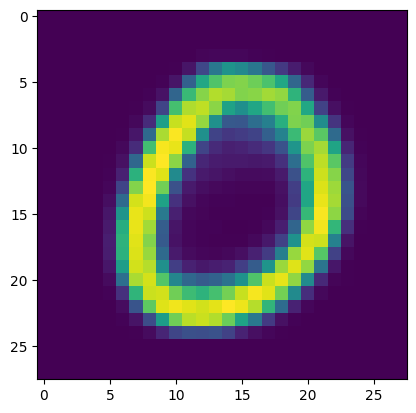

In [13]:
import matplotlib.pyplot as plt
print(z1.max(), z1.min(), z1.std())
plt.imshow(decoder(torch.randn(1, z_size).cuda()).view(28, 28).detach().cpu().numpy())